# Generation of Synthetic Sitelle Data

The problem: How do we get the velocity component of the emission from the Sitelle spectra? This is needed to apply an ORCS fit... 

What are we going to do?
 - Generate Synthetic Sitelle Data for SN3 and the Signals Observation Parameters. We will vary the theta value (offset of pixel on chip), velocity, and broadening components for our five primary emission lines. 
 - Apply a CNN to the data to try and learn the values

In [1]:
import orb.fit
import pylab as pl
import numpy as np
from orb.core import Lines
import random
from astropy.io import fits
import datetime
from tqdm import tqdm_notebook as tqdm
import pymysql
import pandas as pd
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'orb'

In [10]:
# Set Input Parameters
output_dir = 'Data/'
# Set observation parameters
step = 2943
order = 8
resolution = 5000
vel_num = 5000  # Number of Velocity Values Sampled
broad_num = 1000  # Number of Broadening Values Sampled
theta_num = 1  # Number of Theta Values Sampled
num_syn = 1  # Number of Synthetic Spectra 

In [11]:
# Sample theta parameter
thetas_ = np.random.uniform(11.96,11.96,theta_num)#11.8,19.6,theta_num) 
# Sample velocity
vel_ = np.random.uniform(-200,500,vel_num)
# Sample broadening
broad_ = np.random.uniform(10,200,broad_num)
# Same resolution
res_ = np.random.uniform(resolution-200, resolution, 200)

In [12]:
# Now we need to get our emission lines
halpha_cm1 = Lines().get_line_cm1('Halpha')
NII6548_cm1 = Lines().get_line_cm1('[NII]6548')
NII6583_cm1 = Lines().get_line_cm1('[NII]6583')
SII6716_cm1 = Lines().get_line_cm1('[SII]6716')
SII6731_cm1 = Lines().get_line_cm1('[SII]6731')

In [13]:
# We must alo get our flux values from 3mdb
# First we load in the parameters needed to login to the sql database
MdB_HOST='3mdb.astro.unam.mx'
MdB_USER='OVN_user'
MdB_PASSWD='oiii5007'
MdB_PORT='3306'
MdB_DBs='3MdBs'
MdB_DBp='3MdB'
MdB_DB_17='3MdB_17'
# Now we connect to the database
co = pymysql.connect(host=MdB_HOST, db=MdB_DB_17, user=MdB_USER, passwd=MdB_PASSWD)
# Now we get the lines we want
ampls = pd.read_sql("select H__1_656281A as h1, N__2_654805A as n1, N__2_658345A as n2, \
                  S__2_673082A  as s1, S__2_671644A as s2,   \
                  com1 as U, com2 as gf, com4 as ab \
                  from tab_17 \
                  where ref = 'BOND'"
                    , con=co)

# sims = pd.read_sql("SELECT ref FROM tab", con=co)
# sims['ref'].unique() 

(15200.0, 15300.0)

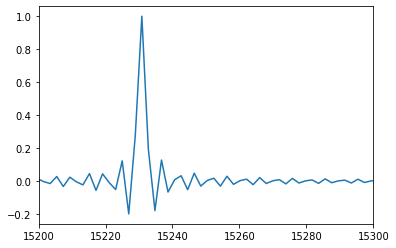

In [14]:
sim_vals = ampls.iloc[1]
axis_corr = 1 / np.cos(np.deg2rad(11.96))
spectrum = orb.fit.create_cm1_lines_model([halpha_cm1], [sim_vals['h1']/sim_vals['h1']],
                                              step, order, resolution, 11.96, fmodel='sincgauss',
                                              sigma=1, vel=100)
spectrum_axis = orb.utils.spectrum.create_cm1_axis(np.size(spectrum), step, order, corr=axis_corr)
plt.plot(spectrum_axis, spectrum)
plt.xlim(15200, 15300)

In [16]:
len(ampls)

113420

We are on spectrum number 0


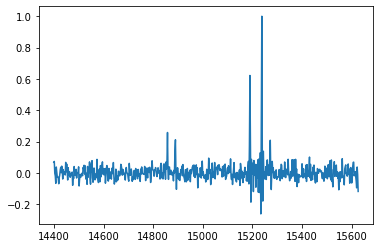

In [30]:
# We now can model the lines. For the moment, we will assume all lines have the same velocity and broadening
# Do this for randomized combinations of vel_ and broad_
for spec_ct in range(1):
    if spec_ct%1000 == 0:
        print("We are on spectrum number %i"%spec_ct)
    pick_new = True
    # Randomly select velocity and broadening parameter and theta
    velocity = random.choice(vel_)
    broadening = random.choice(broad_)
    resolution = random.choice(res_)
    theta = 11.96#random.choice(thetas_)
    axis_corr = 1 / np.cos(np.deg2rad(theta))
    # Randomly Select a M3db simulation
    #while pick_new:
        # Only pick simulation if the n1 and s1 lines are detectable
    while pick_new:
        sim_num = random.randint(0,len(ampls)-1)
        #print(sim_num)
        sim_vals = ampls.iloc[sim_num]
        #print(sim_vals['h1']/sim_vals['n1'], sim_vals['h1']/sim_vals['s1'])
        if ((sim_vals['h1']/sim_vals['n1'] < 5) and (sim_vals['h1']/sim_vals['s1'] < 8)):
            pick_new = False
    # Next we are going to normalize so that the max value is 1
    max_val = sim_vals[['h1','n1','n2','s1','s2']].max()
    #min_val = sim_vals[['h1','n1','n2','s1','s2']].min() 
    # Now add all of the lines... 
    spectrum = orb.fit.create_cm1_lines_model([halpha_cm1], [sim_vals['h1']/sim_vals['h1']],
                                              step, order, resolution, theta, fmodel='sinc',
                                              sigma=broadening, vel=velocity)
    spectrum += orb.fit.create_cm1_lines_model([NII6548_cm1], [sim_vals['n1']/sim_vals['h1']],
                                              step, order, resolution, theta, fmodel='sinc',
                                              sigma=broadening, vel=velocity)
    spectrum += orb.fit.create_cm1_lines_model([NII6583_cm1], [sim_vals['n2']/sim_vals['h1']],
                                              step, order, resolution, theta, fmodel='sinc',
                                              sigma=broadening, vel=velocity)
    spectrum += orb.fit.create_cm1_lines_model([SII6716_cm1], [sim_vals['s1']/sim_vals['h1']],
                                              step, order, resolution, theta, fmodel='sinc',
                                              sigma=broadening, vel=velocity)
    spectrum += orb.fit.create_cm1_lines_model([SII6731_cm1], [sim_vals['s2']/sim_vals['h1']],
                                              step, order, resolution, theta, fmodel='sinc',
                                              sigma=broadening, vel=velocity)
    # We now add noise
    SNR = np.random.uniform(25,30)
    spectrum += np.random.normal(0.0,1.0/SNR,spectrum.shape)
    spectrum_axis = orb.utils.spectrum.create_cm1_axis(np.size(spectrum), step, order, corr=axis_corr)
    min_ = np.argmin(np.abs(np.array(spectrum_axis)-14400))
    max_ = np.argmin(np.abs(np.array(spectrum_axis)-15700))
    spectrum = spectrum[min_:max_]  ## at R = 5000 -> spectrum[214:558]
    spectrum_axis = spectrum_axis[min_:max_]
    # Normalize Spectrum Values
    spec_max = np.max(spectrum)
    spectrum = [spec_/spec_max for spec_ in spectrum]
    pl.clf()
    pl.plot(spectrum_axis, spectrum)
    #pl.savefig('Plots/spec_%i.png'%spec_ct)
    # Gather information to make Fits file
    col1 = fits.Column(name='Wavenumber', format='E', array=spectrum_axis)
    col2 = fits.Column(name='Flux', format='E', array=spectrum)
    cols = fits.ColDefs([col1, col2])
    hdu = fits.BinTableHDU.from_columns(cols)
    # Header info
    hdr = fits.Header()
    hdr['OBSERVER'] = 'Carter Rhea'
    hdr['COMMENT'] = "Synthetic Spectrum Number: %i"%spec_ct
    hdr['TIME'] =  datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    hdr['VELOCITY'] = velocity
    hdr['BROADEN'] = broadening
    hdr['THETA'] = theta
    hdr['RES'] = resolution
    hdr['SIM'] = 'BOND'
    hdr['SNR'] = SNR
    hdr['SIM_NUM'] = sim_num
    empty_primary = fits.PrimaryHDU(header=hdr)
    hdul = fits.HDUList([empty_primary, hdu])
    hdul.writeto(output_dir+'Spectrum_%i.fits'%spec_ct, overwrite=True)
    

## Reference Spectrum